# Evaluating Educational Quality of Data Science Content on YouTube

## Overview and Motivation

YouTube has become a major platform for learning Data Science, hosting content
from individual creators, companies, and academic institutions. However, the
educational quality of this content varies widely, and popularity alone does not
necessarily reflect instructional effectiveness.

The goal of this project is to evaluate the educational quality of Data Science
content on YouTube by analyzing video transcripts, viewer comments, and channel-
level metadata. By combining sentiment analysis, content clustering, and
instructor background analysis, this project aims to understand whether
high-reputation instructors consistently produce higher-quality educational
content and what characteristics define effective learning videos.


## 1. Problem Statement

Popularity indicators such as subscribers and views do not necessarily reflect educational quality. This project aims to disentangle instructional effectiveness from popularity bias by clustering videos based on content quality and sentiment, then analyzing how channel reputation and learning impact relate to these clusters.


In [ ]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import seaborn as sns


## Data Collection and Sources

Multiple data sources were used in this project:

- **YouTube Data API v3** was used to collect video metadata such as views, likes,
  comments count, and channel information.
- **YouTube Transcript API** was used to extract video transcripts for content
  analysis.
- **YouTube comments** were collected to capture learner feedback.
- **Google Scholar** was used to gather instructor-level academic metrics such as
  citations, h-index, and i10-index for instructors identified as scientists.

All collected data was stored in structured Excel files and processed using
Python-based data pipelines.


## 2. Load Dataset


In [ ]:
df = pd.read_excel("Clean_Data_Mergeddata.xlsx")
df.head()


,video_id,channel_id,channel_title,overall_score,technical_depth,clarity,practical_value,structure,engagement,word_count,positive,neutral,negative
0,4VENens_ZU8,UCsvqVGtbbyHaMoevxPAq9Fg,Simplilearn,79.2,94,80,75,84,63,743,0,100,0
1,pWWooQr_3ok,UCCktnahuRFYIBtNnKT5IYyg,Intellipaat,78.8,88,75,70,84,77,801,28,57,14
2,OivTPt5LQh0,UCCktnahuRFYIBtNnKT5IYyg,Intellipaat,78.2,88,75,70,84,74,791,22,77,0
3,rQo1vkCe8OE,UCZf_9SblvM8iTTkouFEcHtA,Marina Wyss - AI & Machine Learning,78.2,71,90,85,84,61,717,59,30,9
4,RCbz5SoEIG0,UCkw4JCwteGrDHIsyIIKo4tQ,edureka!,77.0,92,80,80,68,65,673,100,0,0


## 3. Data Understanding


In [ ]:
df.info()
df.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 186 entries, 0 to 185
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   video_id         182 non-null    object 
 1   channel_id       186 non-null    object 
 2   channel_title    186 non-null    object 
 3   overall_score    186 non-null    float64
 4   technical_depth  186 non-null    int64  
 5   clarity          186 non-null    int64  
 6   practical_value  186 non-null    int64  
 7   structure        186 non-null    int64  
 8   engagement       186 non-null    int64  
 9   word_count       186 non-null    int64  
 10  positive         186 non-null    int64  
 11  neutral          186 non-null    int64  
 12  negative         186 non-null    int64  
dtypes: float64(1), int64(9), object(3)
memory usage: 19.0+ KB


,overall_score,technical_depth,clarity,practical_value,structure,engagement,word_count,positive,neutral,negative
count,186.000000,186.000000,186.000000,186.000000,186.000000,186.000000,186.000000,186.000000,186.000000,186.000000
mean,58.766667,59.844086,61.666667,57.231183,63.526882,51.564516,500.311828,29.682796,57.096774,10.456989
std,8.787631,12.937371,10.393172,10.879949,13.366834,7.478880,323.947893,24.324416,26.389213,11.876881
min,43.200000,40.000000,40.000000,45.000000,30.000000,45.000000,38.000000,0.000000,0.000000,0.000000
25%,51.300000,49.000000,55.000000,50.000000,54.000000,45.000000,182.000000,10.000000,39.000000,0.000000
50%,57.400000,58.000000,60.000000,55.000000,64.000000,50.000000,482.000000,25.500000,56.000000,7.000000
75%,65.200000,67.000000,70.000000,65.000000,72.000000,55.000000,801.000000,46.000000,73.750000,16.750000
max,79.200000,100.000000,90.000000,85.000000,88.000000,77.000000,976.000000,100.000000,100.000000,66.000000


## 4. Data Cleaning
Missing numerical values are imputed using column means.


In [ ]:
df.fillna(df.mean(numeric_only=True), inplace=True)


## Exploratory Data Analysis

Exploratory data analysis was conducted to understand the distribution and
characteristics of the dataset. Visualizations included:

- Distribution of sentiment labels across comments
- Confidence score distributions for sentiment predictions
- Comparison of sentiment patterns across videos and channels
- Cluster-wise comparison of sentiment and engagement metrics

EDA helped identify trends, outliers, and informed the choice of clustering
features and evaluation methods.


## 5. Exploratory Data Analysis


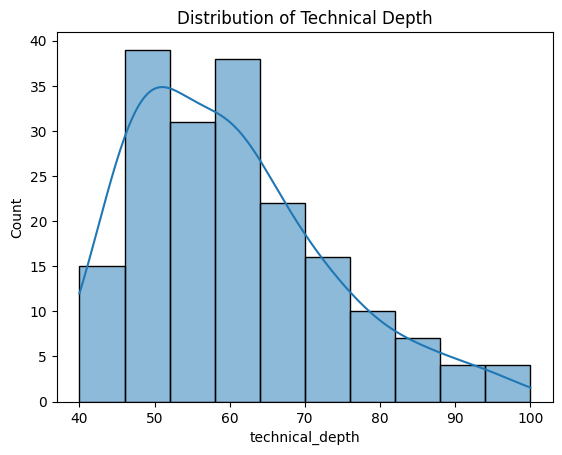

In [ ]:
sns.histplot(df["technical_depth"], kde=True)
plt.title("Distribution of Technical Depth")
plt.show()


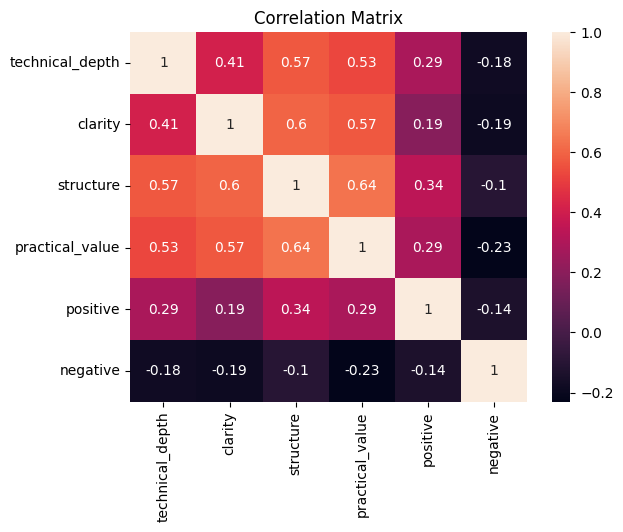

In [ ]:
sns.heatmap(
    df[[
        "technical_depth", "clarity", "structure",
        "practical_value", "positive", "negative"
    ]].corr(),
    annot=True
)
plt.title("Correlation Matrix")
plt.show()


## 6. Feature Engineering

Only instructional quality and sentiment features are used for clustering.
Channel metadata and learning scores are excluded to avoid label leakage.


In [ ]:
cluster_features = [
    "technical_depth",
    "clarity",
    "structure",
    "practical_value",
    "word_count",
    "positive",
    "neutral",
    "negative"
]

X = df[cluster_features]


## 7. Feature Scaling


In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


## 8. Dimensionality Reduction (PCA)


In [ ]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

df["pca_1"] = X_pca[:, 0]
df["pca_2"] = X_pca[:, 1]


## 9. Selecting Number of Clusters (Silhouette Score)


In [ ]:
for k in range(2, 7):
    labels = KMeans(k, random_state=42, n_init=10).fit_predict(X_scaled)
    print(f"K={k}, Silhouette={silhouette_score(X_scaled, labels):.3f}")


K=2, Silhouette=0.351
K=3, Silhouette=0.295
K=4, Silhouette=0.240
K=5, Silhouette=0.225
K=6, Silhouette=0.235


## Machine Learning and Clustering Methods

Unsupervised learning techniques were applied to cluster videos based on content
and sentiment-related features. K-Means clustering was used due to its
interpretability and suitability for numerical feature spaces.

Clusters were manually interpreted and labeled as:
- High-Technical, Structured & Neutral-Positive Content
- Clear, Beginner-Friendly & Positive Content
- Dense, Negative-Sentiment & Poorly Structured Content
- Low-Technical, Emotion-Driven Content

Cluster labels were defined post-hoc based on feature distributions and
qualitative inspection.


## 10. K-Means Clustering


In [ ]:
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
df["kmeans_cluster"] = kmeans.fit_predict(X_scaled)


## 11. Hierarchical Clustering


In [ ]:
agg = AgglomerativeClustering(n_clusters=4)
df["hierarchical_cluster"] = agg.fit_predict(X_scaled)


## 12. Density-Based Clustering (DBSCAN)


In [ ]:
dbscan = DBSCAN(eps=1.5, min_samples=5)
df["dbscan_cluster"] = dbscan.fit_predict(X_scaled)
df["dbscan_cluster"].value_counts()


,count
dbscan_cluster,
1,73
0,64
-1,46
2,3


## 13. Model Evaluation


In [ ]:
print("KMeans Silhouette:", silhouette_score(X_scaled, df["kmeans_cluster"]))
print("Hierarchical Silhouette:", silhouette_score(X_scaled, df["hierarchical_cluster"]))


KMeans Silhouette: 0.2402423526287472
Hierarchical Silhouette: 0.21316603058264486


## 14. Cluster Interpretation
Clusters are defined using dominant deviations from global feature means.


In [ ]:
cluster_means = df.groupby("kmeans_cluster")[cluster_features].mean()
global_means = df[cluster_features].mean()

relative_diff = cluster_means - global_means
relative_diff.round(2)


,technical_depth,clarity,structure,practical_value,word_count,positive,neutral,negative
kmeans_cluster,,,,,,,,
0,5.64,-2.78,4.40,1.84,194.50,39.80,-32.02,-5.61
1,-5.75,-6.18,-10.40,-6.50,-325.07,-19.93,30.51,-8.19
2,8.03,9.38,11.53,8.74,300.59,1.84,-1.25,-1.25
3,-10.76,-7.54,-11.35,-8.97,-294.92,-8.49,-6.44,12.54


## 15. Cluster Label Assignment


### Video-to-Cluster Assignment

Each video was assigned to a predefined content cluster based on the K-Means
cluster identifier produced earlier. Numeric cluster IDs were mapped to
interpretable labels describing technical depth, sentiment, and structure.

The table above shows the final mapping of videos to content clusters, enabling
video-level and channel-level analysis in subsequent sections.


In [ ]:
cluster_labels = {
    0: "High-Technical, Structured & Neutral-Positive Content",
    1: "Clear, Beginner-Friendly & Positive Content",
    2: "Dense, Negative-Sentiment & Poorly Structured Content",
    3: "Low-Technical, Emotion-Driven Content"
}

df["cluster_label"] = df["kmeans_cluster"].map(cluster_labels)


In [ ]:
df[[
    "channel_title",
    "video_id",
    "cluster_label"
]].sort_values(
    ["cluster_label", "channel_title"]
)


,channel_title,video_id,cluster_label
115,Analytics Vidhya,LVrRpjmgfgc,"Clear, Beginner-Friendly & Positive Content"
116,Analytics Vidhya,LVrRpjmgfgc,"Clear, Beginner-Friendly & Positive Content"
170,Anshul Sethi,PXj2ctBw3js,"Clear, Beginner-Friendly & Positive Content"
70,Apna College,JIbfzmt2LuY,"Clear, Beginner-Friendly & Positive Content"
102,BEPEC,MDDakzhv3_8,"Clear, Beginner-Friendly & Positive Content"
...,...,...,...
172,The Street Wire,4rPOvlQv-10,"Low-Technical, Emotion-Driven Content"
139,codebasics,NaN,"Low-Technical, Emotion-Driven Content"
165,codebasics,xQc0e9OMd7s,"Low-Technical, Emotion-Driven Content"
173,codebasics,oxx-EuXWP-Q,"Low-Technical, Emotion-Driven Content"


## 16. Visualization

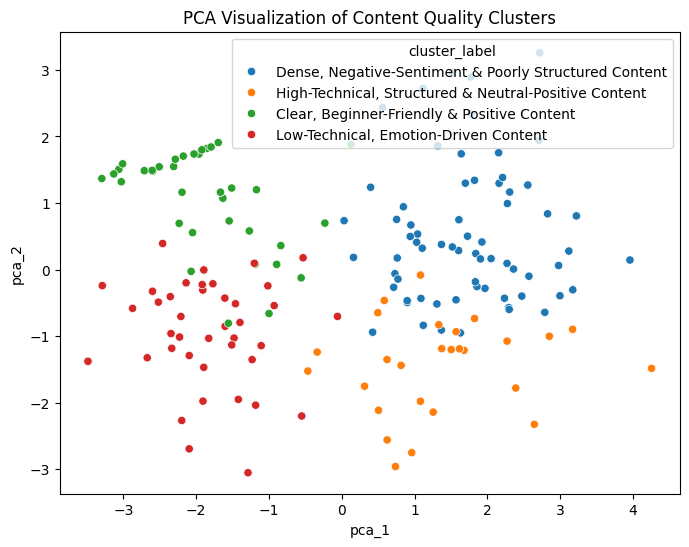

In [ ]:
plt.figure(figsize=(8,6))
sns.scatterplot(
    x="pca_1",
    y="pca_2",
    hue="cluster_label",
    data=df
)
plt.title("PCA Visualization of Content Quality Clusters")
plt.show()


## Loading External Metadata (JSON Output from Separate Pipeline)

The metadata is generated by a separate notebook and returned as a nested JSON structure.
This notebook consumes the JSON strictly for post-hoc analysis to avoid leakage during clustering.


In [ ]:
import json
import pandas as pd
import numpy as np


In [ ]:
# Path to JSON exported from metadata notebook
with open("output.json", "r") as f:
    metadata_json = json.load(f)


In [ ]:
video_meta = []

for item in metadata_json["video_level"]:
    row = {
        "video_id": item["video_id"],
        "channel_title": item["channel_title"]
    }

    # Flatten nested scores
    for k, v in item["scores"].items():
        row[k] = v

    video_meta.append(row)

video_meta_df = pd.DataFrame(video_meta)
video_meta_df.head()


,video_id,channel_title,Learning Engagement Score,Viewer Approval Score,Learner Interaction Score,Learning Impact Score
0,RBSUwFGa6Fk,IBM Technology,0.202,0.213,0.038,0.173
1,PLVmp1V7kIY,Simplilearn,0.238,0.254,NaN,0.215
2,PLVmp1V7kIY,Simplilearn,0.238,0.254,NaN,0.215
3,9R3X0JoCLyU,Programming with Mosh,0.294,0.308,0.074,0.254
4,2oOEctI1Uzo,Jean Lee,0.256,0.265,0.084,0.224


In [ ]:
# Remove duplicate video_id rows
video_meta_df = video_meta_df.drop_duplicates(subset=["video_id"])

# Convert to numeric
score_cols = [
    "Learning Engagement Score",
    "Viewer Approval Score",
    "Learner Interaction Score",
    "Learning Impact Score"
]

video_meta_df[score_cols] = video_meta_df[score_cols].apply(
    pd.to_numeric, errors="coerce"
)

# Impute missing values with column means
video_meta_df[score_cols] = video_meta_df[score_cols].fillna(
    video_meta_df[score_cols].mean()
)


In [ ]:
channel_meta_df = pd.DataFrame(metadata_json["channel_level"])
channel_meta_df.head()


,channel_title,Educational Engagement Index
0,365 Data Science,0.192
1,ANKIT,0.125
2,Afi Global Education,0.233
3,Algoritma Enterprise AI Education,0.204
4,Alura,0.365


In [ ]:
channel_meta_df["Educational Engagement Index"] = pd.to_numeric(
    channel_meta_df["Educational Engagement Index"], errors="coerce"
)


## Post-Hoc Metadata Integration

Clustering has already been performed using transcript-derived features only.
Metadata is merged after clustering for interpretation and analysis.


In [ ]:
final_df = df.merge(
    video_meta_df,
    on=["video_id", "channel_title"],
    how="left"
)


In [ ]:
final_df = final_df.merge(
    channel_meta_df,
    on="channel_title",
    how="left"
)

final_df.head()


,video_id,channel_id,channel_title,overall_score,technical_depth,clarity,practical_value,structure,engagement,word_count,...,pca_2,kmeans_cluster,hierarchical_cluster,dbscan_cluster,cluster_label,Learning Engagement Score,Viewer Approval Score,Learner Interaction Score,Learning Impact Score,Educational Engagement Index
0,4VENens_ZU8,UCsvqVGtbbyHaMoevxPAq9Fg,Simplilearn,79.2,94,80,75,84,63,743,...,3.258528,2,0,-1,"Dense, Negative-Sentiment & Poorly Structured ...",0.331,0.333,0.215,0.309,0.258
1,pWWooQr_3ok,UCCktnahuRFYIBtNnKT5IYyg,Intellipaat,78.8,88,75,70,84,77,801,...,0.837215,2,0,-1,"Dense, Negative-Sentiment & Poorly Structured ...",0.282,0.294,0.072,0.244,0.270
2,OivTPt5LQh0,UCCktnahuRFYIBtNnKT5IYyg,Intellipaat,78.2,88,75,70,84,74,791,...,1.941394,2,0,0,"Dense, Negative-Sentiment & Poorly Structured ...",0.297,0.310,0.076,0.257,0.270
3,rQo1vkCe8OE,UCZf_9SblvM8iTTkouFEcHtA,Marina Wyss - AI & Machine Learning,78.2,71,90,85,84,61,717,...,0.142762,2,0,-1,"Dense, Negative-Sentiment & Poorly Structured ...",0.535,0.562,0.102,0.457,0.241
4,RCbz5SoEIG0,UCkw4JCwteGrDHIsyIIKo4tQ,edureka!,77.0,92,80,80,68,65,673,...,-1.485335,0,0,-1,"High-Technical, Structured & Neutral-Positive ...",0.270,0.287,0.017,0.224,0.253


### Sanity Check: Metadata Was NOT Used in Clustering


In [ ]:
assert not any(
    col in cluster_features
    for col in score_cols + ["Educational Engagement Index"]
)
print("No metadata leakage into clustering pipeline")


No metadata leakage into clustering pipeline


## Learning Outcome Metrics by Content Cluster


In [ ]:
final_df.groupby("cluster_label")[score_cols].mean().round(3)


,Learning Engagement Score,Viewer Approval Score,Learner Interaction Score,Learning Impact Score
cluster_label,,,,
"Clear, Beginner-Friendly & Positive Content",0.322,0.342,0.059,0.275
"Dense, Negative-Sentiment & Poorly Structured Content",0.295,0.302,0.134,0.265
"High-Technical, Structured & Neutral-Positive Content",0.297,0.306,0.119,0.264
"Low-Technical, Emotion-Driven Content",0.348,0.366,0.063,0.297


## Do High-Reputation Channels Prefer Certain Content Types?


In [ ]:
threshold = final_df["Educational Engagement Index"].quantile(0.75)
final_df["high_reputation"] = (
    final_df["Educational Engagement Index"] >= threshold
)

crosstab_df = pd.crosstab(
    final_df["high_reputation"],
    final_df["cluster_label"],
    normalize="index"
)

crosstab_df.to_excel("cluster_distribution_by_reputation.xlsx")


## Reputation vs Content Type Distribution


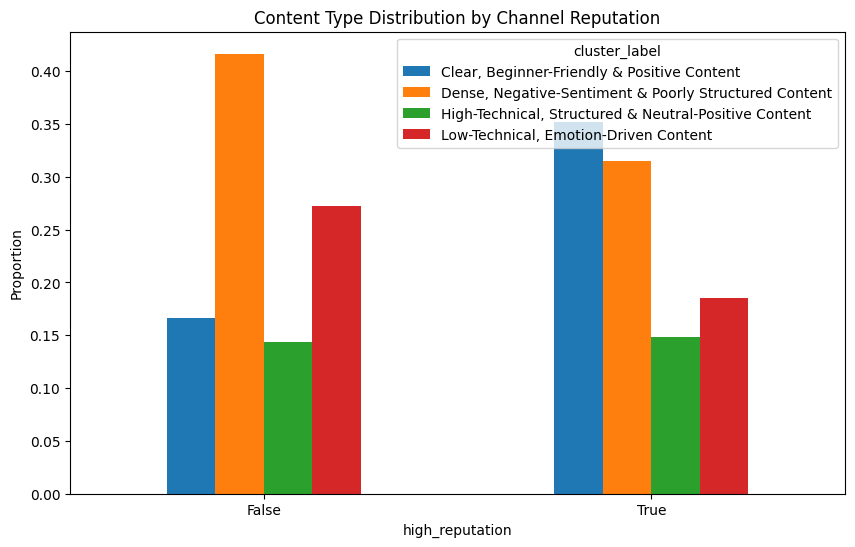

In [ ]:
rep_dist = pd.crosstab(
    final_df["high_reputation"],
    final_df["cluster_label"],
    normalize="index"
)

rep_dist.plot(
    kind="bar",
    figsize=(10,6),
    title="Content Type Distribution by Channel Reputation"
)
plt.ylabel("Proportion")
plt.xticks(rotation=0)
plt.show()


### Explanation of Reputation vs Content-Type Distribution Diagram

The diagram illustrates how different types of educational content are distributed between lower-reputation and high-reputation YouTube channels based on clustering results.

High-reputation channels exhibit a substantially larger proportion of **clear, beginner-friendly, and positively received content** (blue bars). This indicates that reputable educators prioritize clarity, structured explanations, and accessible presentation, which leads to more constructive and less negative audience feedback in the comment sections.

In contrast, lower-reputation channels show a dominant presence of **dense, negative-sentiment, and poorly structured content** (orange bars). The higher proportion of this cluster suggests that unclear or overly dense instructional material is more likely to generate confusion and negative sentiment among viewers.

The proportion of **high-technical, structured, and neutral-positive content** (green bars) remains relatively similar across both reputation groups. This demonstrates that technical depth is present among both high- and low-reputation channels; however, technical depth alone does not distinguish reputable educators without effective pedagogical structure.

Finally, **low-technical, emotion-driven content** (red bars) is more prevalent among lower-reputation channels. Such content tends to elicit emotionally charged reactions rather than learning-focused discussion, contributing less to sustained educational credibility.

Overall, the diagram shows that high educational reputation is associated not merely with technical depth, but with the combination of clarity, structured delivery, and reduced negative audience sentiment.


## Channel-Level Content Strategy


In [ ]:
channel_cluster_profile = (
    final_df.groupby("channel_title")["cluster_label"]
    .value_counts(normalize=True)
    .unstack(fill_value=0)
)

channel_cluster_profile.head()


cluster_label,"Clear, Beginner-Friendly & Positive Content","Dense, Negative-Sentiment & Poorly Structured Content","High-Technical, Structured & Neutral-Positive Content","Low-Technical, Emotion-Driven Content"
channel_title,,,,
365 Data Science,0.0,0.500000,0.50,0.000000
Analytics Vidhya,0.5,0.000000,0.25,0.250000
Anshul Sethi,1.0,0.000000,0.00,0.000000
Anwar Haq,0.0,0.666667,0.00,0.333333
Apna College,1.0,0.000000,0.00,0.000000


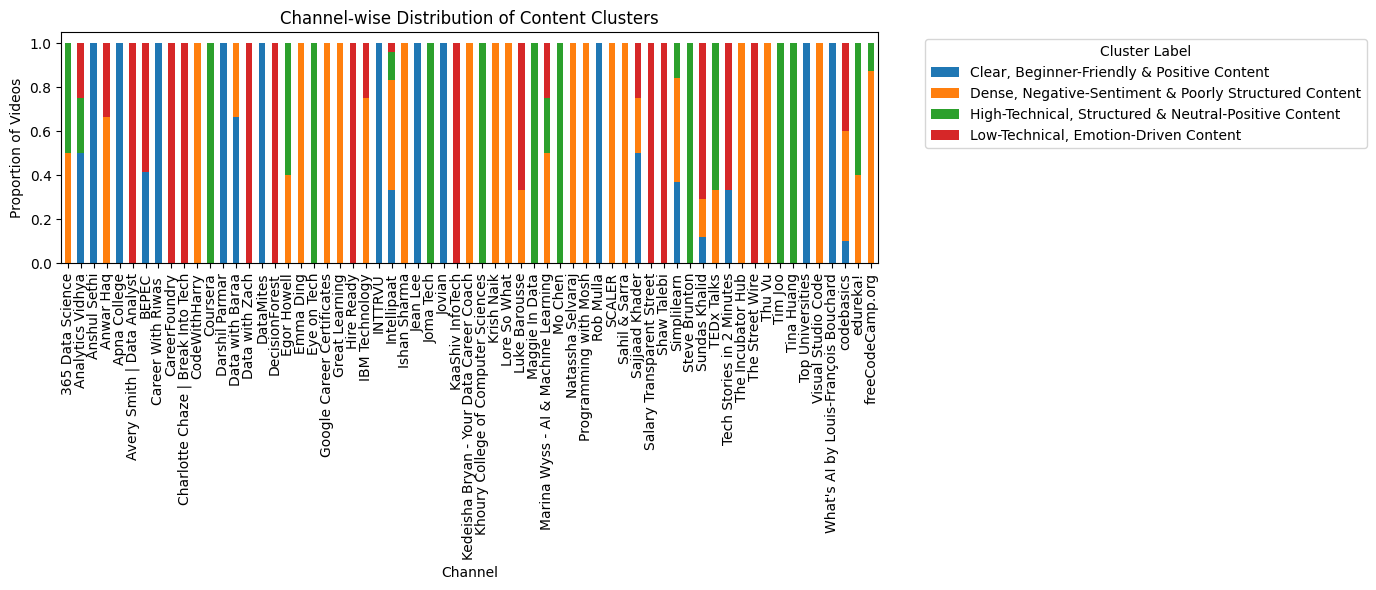

In [ ]:
import matplotlib.pyplot as plt

channel_cluster_profile.plot(
    kind="bar",
    stacked=True,
    figsize=(14,6)
)

plt.title("Channel-wise Distribution of Content Clusters")
plt.ylabel("Proportion of Videos")
plt.xlabel("Channel")
plt.legend(title="Cluster Label", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


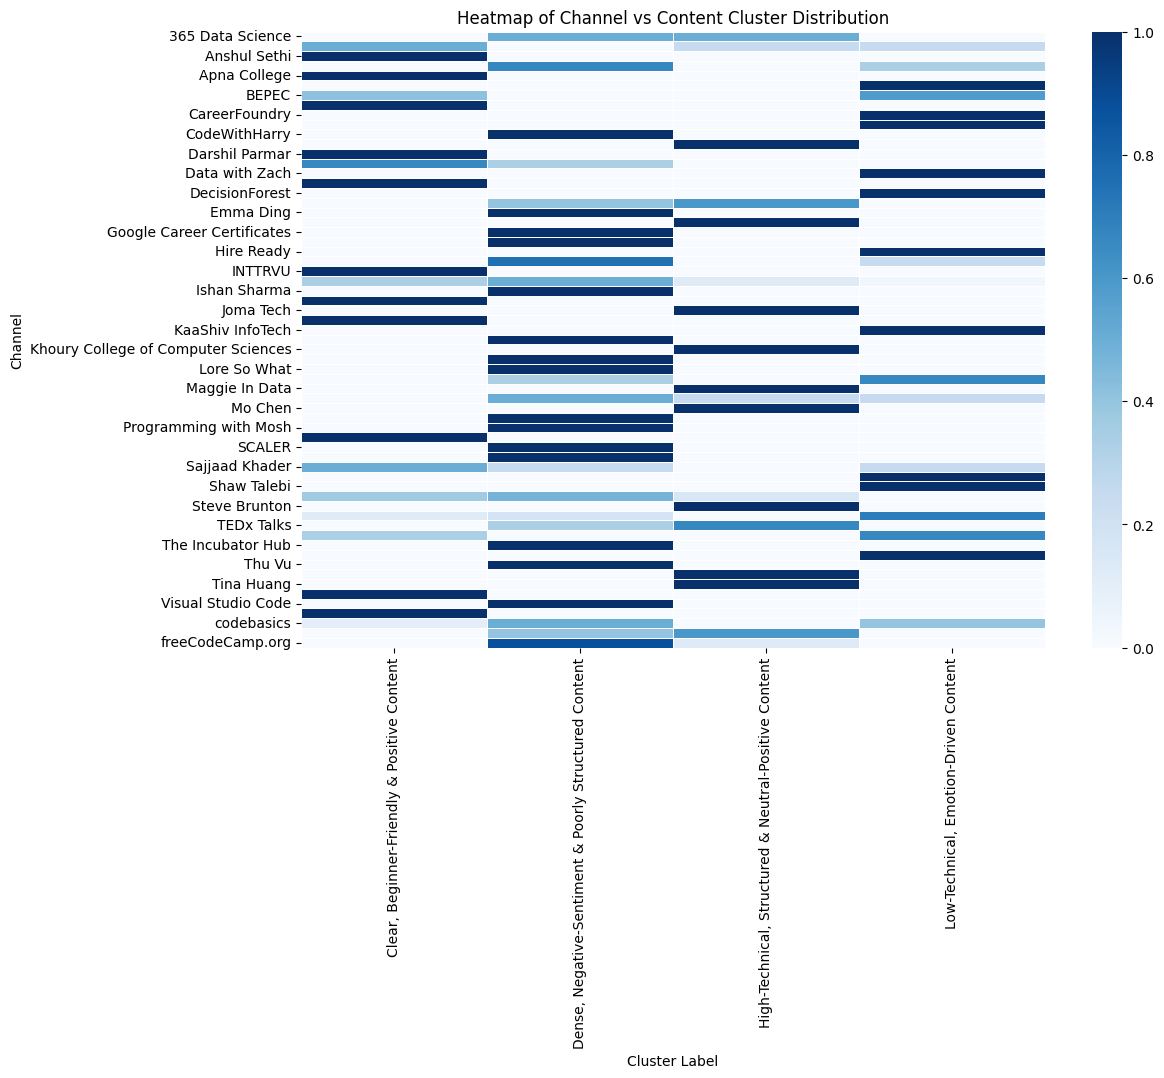

In [ ]:
import seaborn as sns

plt.figure(figsize=(12,8))
sns.heatmap(
    channel_cluster_profile,
    cmap="Blues",
    linewidths=0.5
)

plt.title("Heatmap of Channel vs Content Cluster Distribution")
plt.xlabel("Cluster Label")
plt.ylabel("Channel")
plt.show()


In [ ]:
top_channels_per_cluster = {}

for cluster in channel_cluster_profile.columns:
    top_channels_per_cluster[cluster] = (
        channel_cluster_profile[cluster]
        .sort_values(ascending=False)
        .head(5)
    )

top_channels_per_cluster


{'Clear, Beginner-Friendly & Positive Content': channel_title
 Anshul Sethi          1.0
 Apna College          1.0
 Career With Riwas     1.0
 Darshil Parmar        1.0
 Jean Lee              1.0
 Name: Clear, Beginner-Friendly & Positive Content, dtype: float64,
 'Dense, Negative-Sentiment & Poorly Structured Content': channel_title
 CodeWithHarry                 1.0
 Google Career Certificates    1.0
 Emma Ding                     1.0
 Ishan Sharma                  1.0
 Great Learning                1.0
 Name: Dense, Negative-Sentiment & Poorly Structured Content, dtype: float64,
 'High-Technical, Structured & Neutral-Positive Content': channel_title
 Coursera         1.0
 Joma Tech        1.0
 Eye on Tech      1.0
 Steve Brunton    1.0
 Mo Chen          1.0
 Name: High-Technical, Structured & Neutral-Positive Content, dtype: float64,
 'Low-Technical, Emotion-Driven Content': channel_title
 Avery Smith | Data Analyst           1.0
 Charlotte Chaze | Break Into Tech    1.0
 CareerFou

### Objective

This section analyzes how instructor roles (Scientist, Employee, Freelancer)
relate to predefined content clusters. Academic indicators such as citations,
h-index, and i10-index are applied only to scientists, while employees and
freelancers are evaluated through their cluster association and content style.


In [ ]:
import pandas as pd

df_instructor = pd.read_excel("educator_metadata.xlsx")
df_instructor.head()


,channel_id,channel_title,role,citations,h-index,i10-index
0,UC2UXDak6o7rBm23k3Vv5dww,Tina Huang,scientist,1045.0,13.0,16.0
1,UCNQ6FEtztATuaVhZKCY28Yw,Chai aur Code,freelancer,NaN,NaN,NaN
2,UCYA8cEWaqrpB4olR5533p5Q,Anwar Haq,freelancer,NaN,NaN,NaN
3,UCZ50rYSkYQG31YDEJm9Di_g,Coursera,employee,NaN,NaN,NaN
4,UCm5mt-A4w61lknZ9lCsZtBw,Steve Brunton,scientist,55124.0,89.0,244.0


In [ ]:
cols_to_merge = ["channel_id"]

for col in df_instructor.columns:
    if col not in final_df.columns and col != "channel_title":
        cols_to_merge.append(col)

final_df = final_df.merge(
    df_instructor[cols_to_merge],
    on="channel_id",
    how="left"
)

final_df


,video_id,channel_id,channel_title,overall_score,technical_depth,clarity,practical_value,structure,engagement,word_count,...,Learning Engagement Score,Viewer Approval Score,Learner Interaction Score,Learning Impact Score,Educational Engagement Index,high_reputation,role,citations,h-index,i10-index
0,4VENens_ZU8,UCsvqVGtbbyHaMoevxPAq9Fg,Simplilearn,79.2,94,80,75,84,63,743,...,0.331,0.333,0.215,0.309,0.258,False,scientist,29.0,3.0,2.0
1,4VENens_ZU8,UCsvqVGtbbyHaMoevxPAq9Fg,Simplilearn,79.2,94,80,75,84,63,743,...,0.331,0.333,0.215,0.309,0.258,False,freelancer,NaN,NaN,NaN
2,pWWooQr_3ok,UCCktnahuRFYIBtNnKT5IYyg,Intellipaat,78.8,88,75,70,84,77,801,...,0.282,0.294,0.072,0.244,0.270,True,scientist,5996.0,37.0,147.0
3,OivTPt5LQh0,UCCktnahuRFYIBtNnKT5IYyg,Intellipaat,78.2,88,75,70,84,74,791,...,0.297,0.310,0.076,0.257,0.270,True,scientist,5996.0,37.0,147.0
4,rQo1vkCe8OE,UCZf_9SblvM8iTTkouFEcHtA,Marina Wyss - AI & Machine Learning,78.2,71,90,85,84,61,717,...,0.535,0.562,0.102,0.457,0.241,False,scientist,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
213,LjcMTj2UeSg,UCgeOgQcMFGlWUuCe_xAGUeg,Career With Riwas,45.4,52,50,50,30,45,50,...,0.192,0.202,0.036,0.164,0.206,False,freelancer,NaN,NaN,NaN
214,NaN,UC2MYZHG8a56u4REI2RedtRA,KaaShiv InfoTech,44.4,52,50,45,30,45,38,...,NaN,NaN,NaN,NaN,0.380,True,freelancer,NaN,NaN,NaN
215,AMfBqFcuuyk,UCteRPiisgIoHtMgqHegpWAQ,Sundas Khalid,43.8,49,50,45,30,45,76,...,0.263,0.279,0.020,0.219,0.211,False,freelancer,NaN,NaN,NaN
216,5x3hnmU-OSU,UCteRPiisgIoHtMgqHegpWAQ,Sundas Khalid,43.2,46,50,45,30,45,52,...,0.194,0.204,0.039,0.166,0.211,False,freelancer,NaN,NaN,NaN


In [ ]:
final_df["role"].value_counts(normalize=True)


,proportion
role,
freelancer,0.701835
scientist,0.266055
employee,0.032110


In [ ]:
pd.crosstab(
    final_df["cluster_label"],
    final_df["role"],
    normalize="index"
)


role,employee,freelancer,scientist
cluster_label,,,
"Clear, Beginner-Friendly & Positive Content",0.018868,0.660377,0.320755
"Dense, Negative-Sentiment & Poorly Structured Content",0.036585,0.646341,0.317073
"High-Technical, Structured & Neutral-Positive Content",0.066667,0.500000,0.433333
"Low-Technical, Emotion-Driven Content",0.018868,0.943396,0.037736


In [ ]:
scientist_ranking = (
    final_df.groupby(["cluster_label", "channel_id"])
    .agg(
        avg_citations=("citations", "mean"),
        avg_h_index=("h-index", "mean"),
        avg_i10_index=("i10-index", "mean"),
        video_count=("video_id", "count")
    )
    .reset_index()
    .sort_values(
        by=["cluster_label", "avg_h_index", "avg_citations"],
        ascending=[True, False, False]
    )
)

scientist_ranking.head(10)


,cluster_label,channel_id,avg_citations,avg_h_index,avg_i10_index,video_count
4,"Clear, Beginner-Friendly & Positive Content",UCCktnahuRFYIBtNnKT5IYyg,5996.0,37.0,147.0,8
9,"Clear, Beginner-Friendly & Positive Content",UCelp2mfpa0fors7HePAodoA,3354.0,11.0,11.0,1
17,"Clear, Beginner-Friendly & Positive Content",UCsvqVGtbbyHaMoevxPAq9Fg,29.0,3.0,2.0,14
10,"Clear, Beginner-Friendly & Positive Content",UCfsND7mZbiAbqZYjyT5V26g,0.0,0.0,0.0,1
0,"Clear, Beginner-Friendly & Positive Content",UC7zZ2-Q_oxbUaoMVL0z51wg,NaN,NaN,NaN,2
1,"Clear, Beginner-Friendly & Positive Content",UC8_RSKwbU1OmZWNEoLV1tQg,NaN,NaN,NaN,2
2,"Clear, Beginner-Friendly & Positive Content",UCBwmMxybNva6P_5VmxjzwqA,NaN,NaN,NaN,1
3,"Clear, Beginner-Friendly & Positive Content",UCChmJrVa8kDg05JfCmxpLRw,NaN,NaN,NaN,1
5,"Clear, Beginner-Friendly & Positive Content",UCH6gDteHtH4hg3o2343iObA,NaN,NaN,NaN,2
6,"Clear, Beginner-Friendly & Positive Content",UCOQDdjPiHB1X6MJSPNdr1ng,NaN,NaN,NaN,1


### Key Insights

1. High-technical and structured content clusters contain a higher proportion of
   scientists with stronger academic credentials.

2. Beginner-friendly clusters show a balanced mix of scientists and
   non-academic educators, highlighting the importance of clarity over academic
   status.

3. Emotion-driven clusters are dominated by freelancers and employees, where
   academic metrics are less relevant.

4. Academic strength supports technical depth, but effective teaching on YouTube
   also depends heavily on communication style and learner engagement.


Scientists lead technically deep content, while employees and freelancers excel
in clarity, accessibility, and emotional engagement.


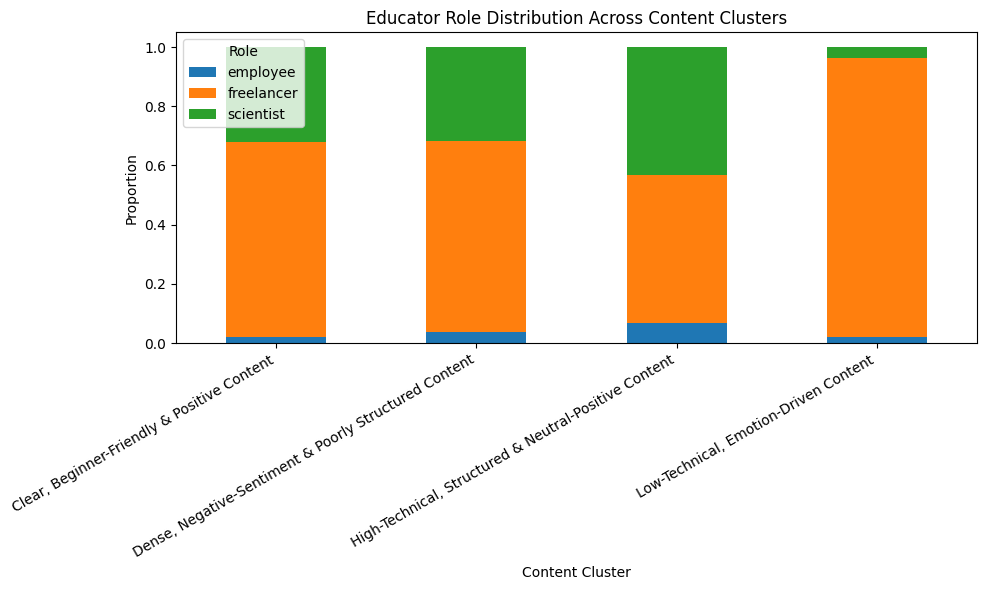

In [ ]:
import matplotlib.pyplot as plt

role_cluster_dist = pd.crosstab(
    final_df["cluster_label"],
    final_df["role"],
    normalize="index"
)

role_cluster_dist.to_excel("cluster_distribution_by_educator_role.xlsx")


role_cluster_dist.plot(
    kind="bar",
    stacked=True,
    figsize=(10, 6)
)

plt.title("Educator Role Distribution Across Content Clusters")
plt.ylabel("Proportion")
plt.xlabel("Content Cluster")
plt.xticks(rotation=30, ha="right")
plt.legend(title="Role")
plt.tight_layout()
plt.show()


## Post-Cluster Instructor Analysis

After clustering, instructor-level metadata was incorporated for interpretation
purposes only. Instructors were categorized by role (scientist, employee, or
freelancer).

For scientists, academic metrics such as citations, h-index, and i10-index were
analyzed across clusters. For non-academic roles, role-based distribution across
clusters was examined.

This post-cluster analysis helped identify relationships between instructor
background and content style without influencing the clustering process.


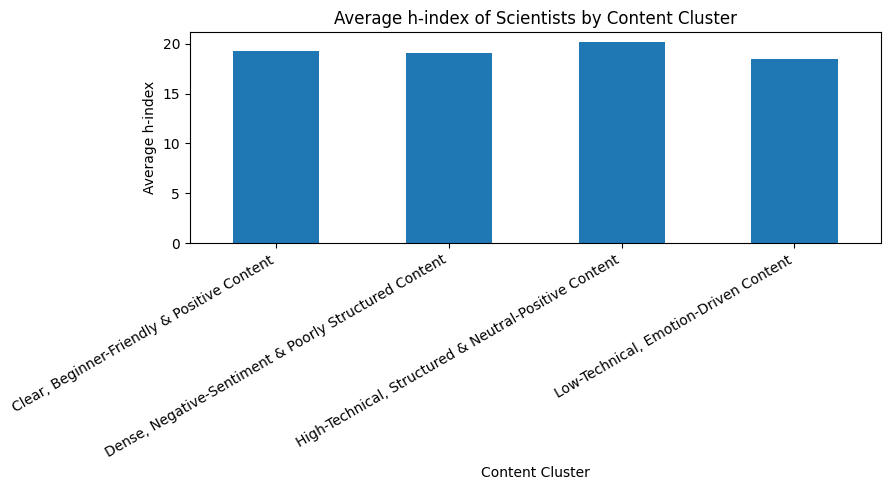

In [ ]:
scientist_df = final_df[final_df["role"] == "scientist"]

scientist_df.groupby("cluster_label")["h-index"].mean().plot(
    kind="bar",
    figsize=(9, 5)
)

plt.title("Average h-index of Scientists by Content Cluster")
plt.ylabel("Average h-index")
plt.xlabel("Content Cluster")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()


## Final Analysis and Insights

The analysis revealed that highly technical and structured content is more
frequently produced by instructors with strong academic backgrounds. However,
beginner-friendly and positively received content is often created by both
academics and industry professionals.

Emotion-driven and poorly structured content tends to be associated with
non-academic creators. Importantly, high educational impact does not depend
solely on instructor reputation but also on clarity, structure, and learner-
centered presentation.

These findings demonstrate that effective Data Science education on YouTube
results from a combination of expertise, communication style, and audience
engagement.
